<a href="https://colab.research.google.com/github/adilghafir/adil-project/blob/main/ondelette_AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
Date
2011-01-03     10.004128
2011-01-04     10.056339
2011-01-05     10.138605
2011-01-06     10.130405
2011-01-07     10.202958
                 ...    
2023-06-12    183.789993
2023-06-13    183.309998
2023-06-14    183.949997
2023-06-15    186.009995
2023-06-16    184.919998
Name: Adj Close, Length: 3135, dtype: float64


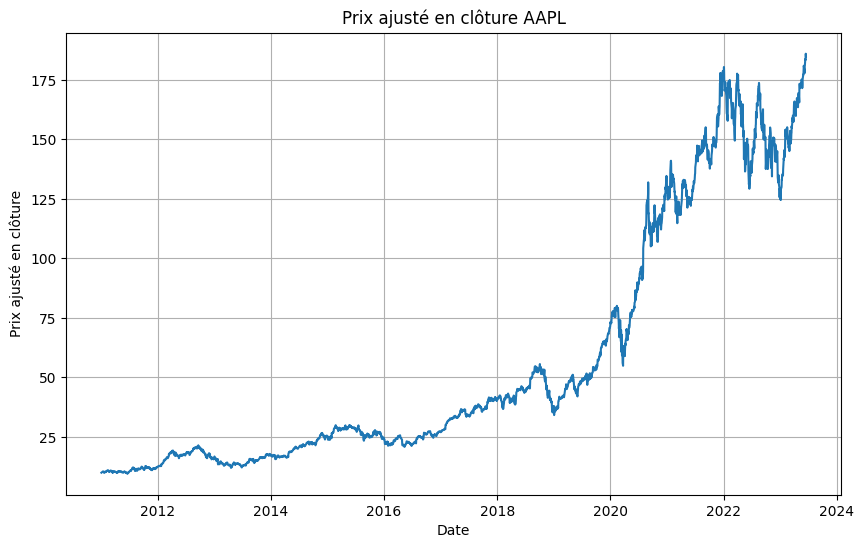

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt

# Spécifiez le symbole de l'action que vous souhaitez importer
symbol = "AAPL"

# Utilisez la fonction `download` de yfinance pour obtenir les données
data = yf.download(symbol, start="2011-01-01", end="2023-06-20")

# Sélectionnez uniquement la colonne "Adj Close"
adj_close = data["Adj Close"]
print(adj_close)

# Créez un graphique avec les données "Adj Close"
plt.figure(figsize=(10, 6))
plt.plot(adj_close)
plt.title("Prix ajusté en clôture AAPL")
plt.xlabel("Date")
plt.ylabel("Prix ajusté en clôture")
plt.grid(True)
plt.show()


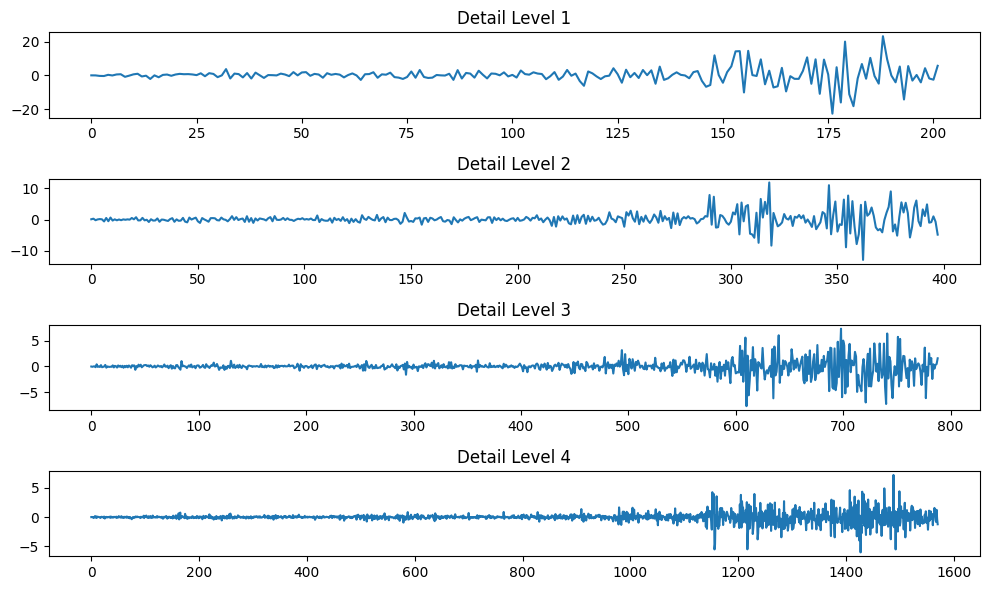

In [4]:
# Convertir les données en une liste
signal = adj_close.values.tolist()

# Effectuer la décomposition en ondelettes
coeffs = pywt.wavedec(signal, 'db4', level=4)

# Récupérer les coefficients de détail et l'approximation
approximation = coeffs[0]
details = coeffs[1:]

# Afficher les coefficients de détail
plt.figure(figsize=(10, 6))
for i, detail_level in enumerate(details):
    plt.subplot(len(details), 1, i+1)
    plt.plot(detail_level)
    plt.title(f"Detail Level {i+1}")
plt.tight_layout()
plt.show()


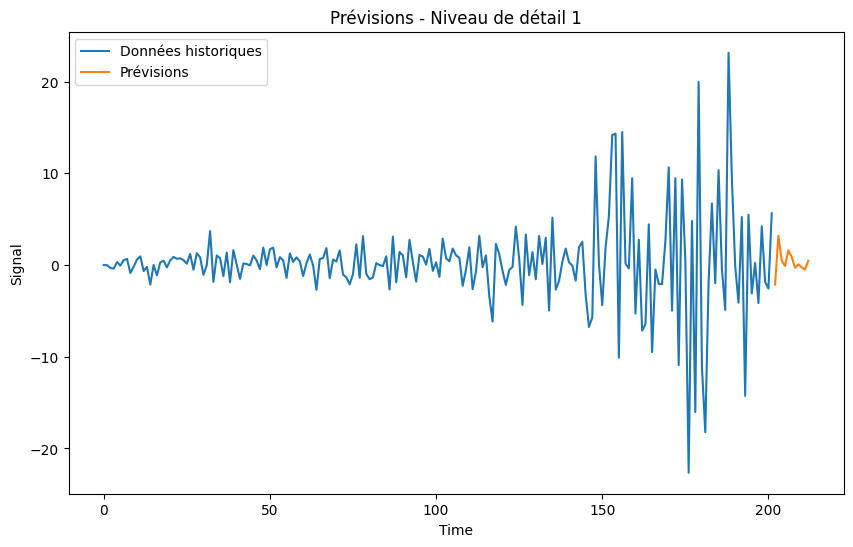

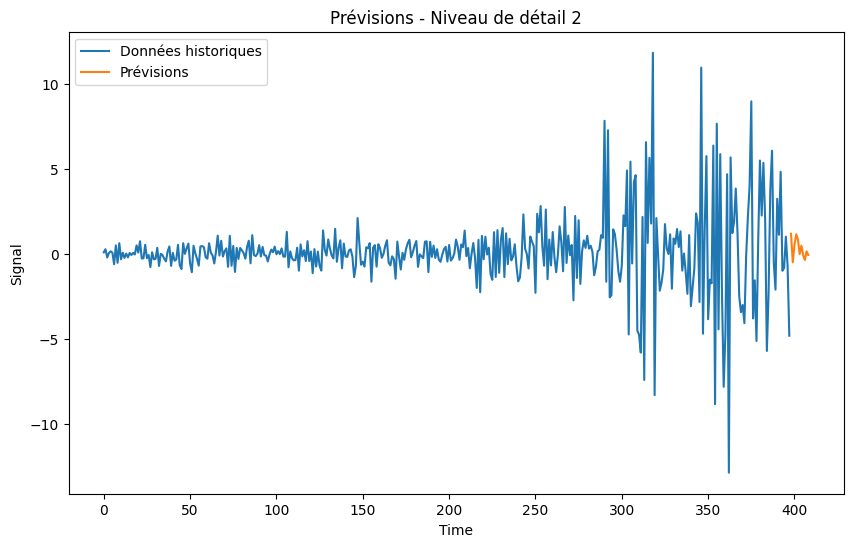

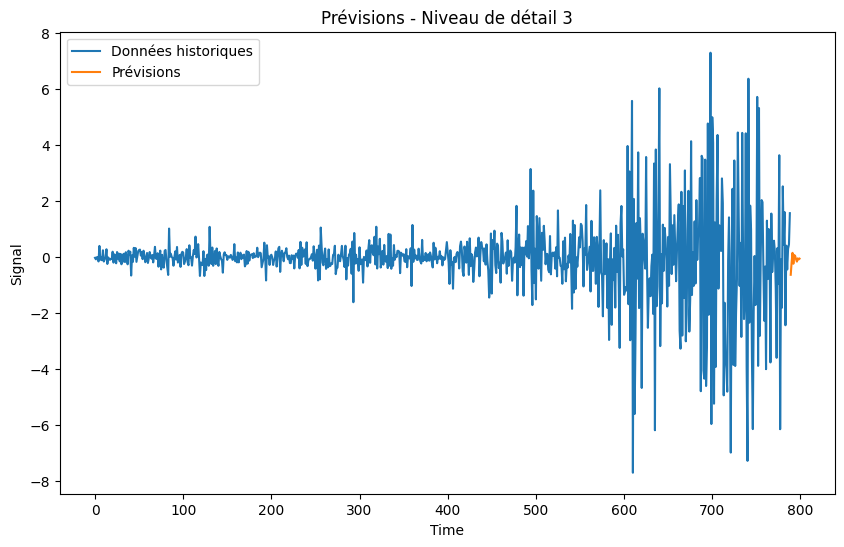

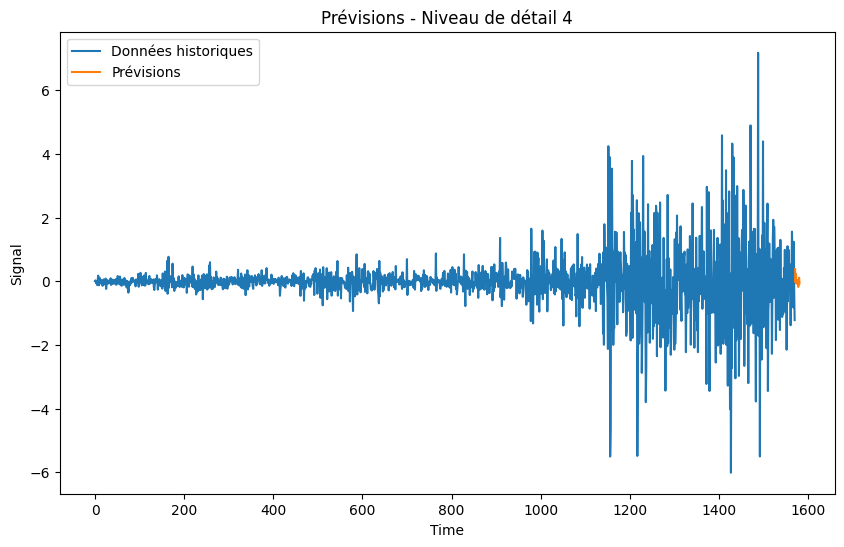

In [3]:

import pywt

from statsmodels.tsa.ar_model import AutoReg


# Convertir les données en une liste
signal = adj_close.values.tolist()

# Effectuer la décomposition en ondelettes
coeffs = pywt.wavedec(signal, 'db4', level=4)

# Prévision des valeurs futures à chaque niveau de détail
for i, detail_level in enumerate(coeffs[1:]):
    # Création du modèle autorégressif (AR) avec un ordre (lag) de 10
    model = AutoReg(detail_level, lags=10)

    # Ajustement du modèle aux données
    model_fit = model.fit()

    # Prévision des valeurs futures à partir du modèle ajusté
    predictions = model_fit.predict(start=len(detail_level), end=len(detail_level) + 10)

    # Affichage des prédictions
    plt.figure(figsize=(10, 6))
    plt.plot(detail_level, label="Données historiques")
    plt.plot(range(len(detail_level), len(detail_level) + len(predictions)), predictions, label="Prévisions")
    plt.title(f"Prévisions - Niveau de détail {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Signal")
    plt.legend()
    plt.show()


In [5]:

from statsmodels.tsa.stattools import adfuller

# Spécifiez le symbole de l'action que vous souhaitez importer
symbol = "AAPL"

# Utilisez la fonction `download` de yfinance pour obtenir les données
data = yf.download(symbol, start="2011-01-01", end="2023-06-20")

# Sélectionnez uniquement la colonne "Adj Close"
adj_close = data["Adj Close"]

# Convertir les données en une liste
signal = adj_close.values.tolist()

# Effectuer la décomposition en ondelettes
coeffs = pywt.wavedec(signal, 'db4', level=4)

# Analyse de la stationarité pour chaque niveau de détail
for i, detail_level in enumerate(coeffs[1:]):
    # Effectuer le test de Dickey-Fuller augmenté
    result = adfuller(detail_level)

    # Extraire la p-value
    p_value = result[1]

    # Interprétation de la stationnarité
    if p_value < 0.05:
        stationarity = "Stationnaire"
    else:
        stationarity = "Non stationnaire"

    # Afficher le résultat
    print(f"Niveau de détail {i+1} : {stationarity} (p-value: {p_value})")





[*********************100%***********************]  1 of 1 completed
Niveau de détail 1 : Stationnaire (p-value: 6.24646328029468e-05)
Niveau de détail 2 : Stationnaire (p-value: 3.5504598130722883e-23)
Niveau de détail 3 : Stationnaire (p-value: 8.841228385024903e-30)
Niveau de détail 4 : Stationnaire (p-value: 7.1331804336095046e-12)


[*********************100%***********************]  1 of 1 completed


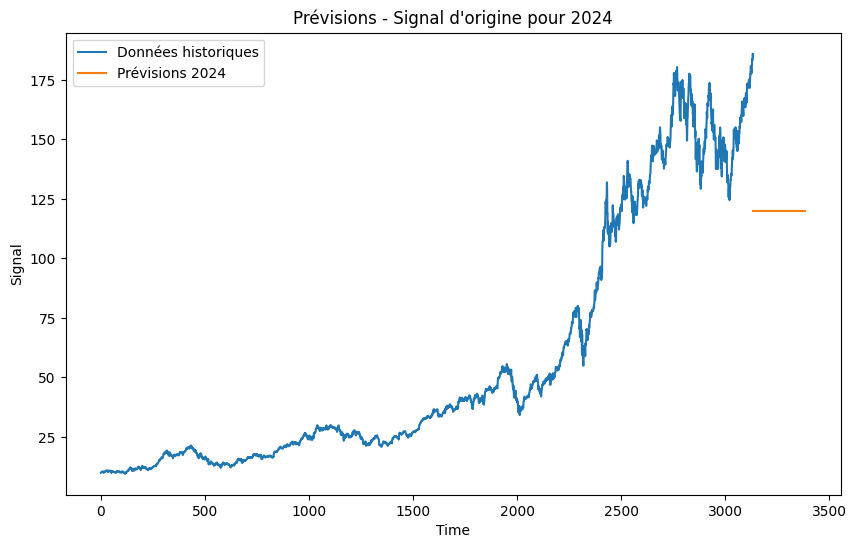

In [6]:
import yfinance as yf
import pywt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Spécifiez le symbole de l'action que vous souhaitez importer
symbol = "AAPL"

# Utilisez la fonction `download` de yfinance pour obtenir les données
data = yf.download(symbol, start="2011-01-01", end="2023-06-20")

# Sélectionnez uniquement la colonne "Adj Close"
adj_close = data["Adj Close"]

# Convertir les données en une liste
signal = adj_close.values.tolist()

# Effectuer la décomposition en ondelettes
coeffs = pywt.wavedec(signal, 'db4', level=4)

# Prévision des valeurs futures à chaque niveau de détail
predictions_combined = []
for i, detail_level in enumerate(coeffs[1:]):
    # Création du modèle autorégressif (AR) avec un ordre (lag) de 10
    model = LinearRegression()

    # Ajustement du modèle aux données
    model.fit(np.arange(len(detail_level)).reshape(-1, 1), detail_level)

    # Prévision des valeurs futures à partir du modèle ajusté
    predictions = model.predict(np.arange(len(detail_level), len(detail_level) + 10).reshape(-1, 1))

    # Ajouter les prédictions au signal combiné
    predictions_combined.append(predictions)

# Transformer les prévisions combinées en un tableau 2D
predictions_combined = np.array(predictions_combined).T

# Répéter les prévisions pour correspondre à la longueur du signal d'origine
repeated_predictions = np.repeat(predictions_combined, len(signal) // len(predictions_combined) + 1, axis=0)
repeated_predictions = repeated_predictions[:len(signal)]

# Régression linéaire pour estimer le signal d'origine
regressor = LinearRegression()
regressor.fit(repeated_predictions, signal)

# Prévision finale du signal d'origine
original_signal_predictions = regressor.predict(repeated_predictions)

# Prévision pour l'année 2024
year_2024_predictions = original_signal_predictions[-252:]

# Afficher les prévisions pour l'année 2024
plt.figure(figsize=(10, 6))
plt.plot(signal, label="Données historiques")
plt.plot(range(len(signal), len(signal) + len(year_2024_predictions)), year_2024_predictions, label="Prévisions 2024")
plt.title("Prévisions - Signal d'origine pour 2024")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()
plt.show()



[*********************100%***********************]  1 of 1 completed


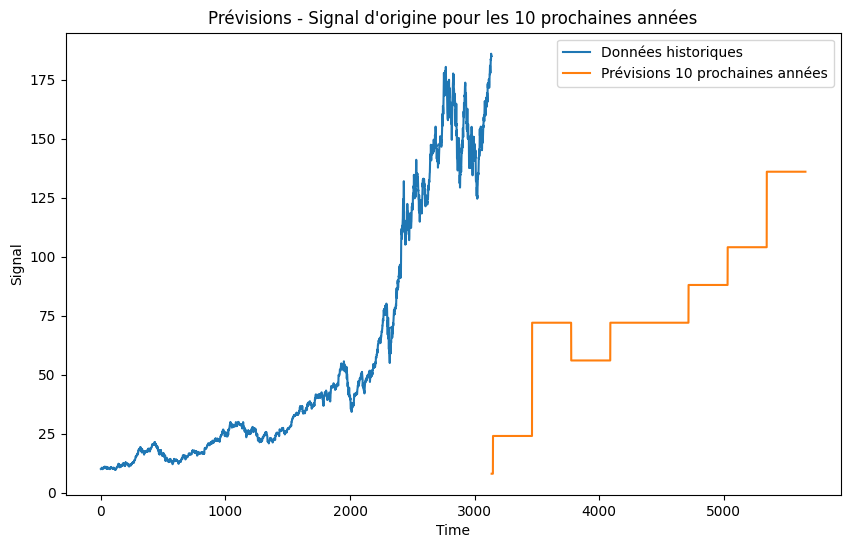

In [7]:
import yfinance as yf
import pywt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import datetime

# Spécifiez le symbole de l'action que vous souhaitez importer
symbol = "AAPL"

# Utilisez la fonction `download` de yfinance pour obtenir les données
data = yf.download(symbol, start="2011-01-01", end=datetime.datetime.now())

# Sélectionnez uniquement la colonne "Adj Close"
adj_close = data["Adj Close"]

# Convertir les données en une liste
signal = adj_close.values.tolist()

# Effectuer la décomposition en ondelettes
coeffs = pywt.wavedec(signal, 'db4', level=4)

# Prévision des valeurs futures à chaque niveau de détail
predictions_combined = []
for i, detail_level in enumerate(coeffs[1:]):
    # Création du modèle autorégressif (AR) avec un ordre (lag) de 10
    model = LinearRegression()

    # Ajustement du modèle aux données
    model.fit(np.arange(len(detail_level)).reshape(-1, 1), detail_level)

    # Prévision des valeurs futures à partir du modèle ajusté
    predictions = model.predict(np.arange(len(detail_level), len(detail_level) + 10).reshape(-1, 1))

    # Ajouter les prédictions au signal combiné
    predictions_combined.append(predictions)

# Transformer les prévisions combinées en un tableau 2D
predictions_combined = np.array(predictions_combined).T

# Répéter les prévisions pour correspondre à la longueur du signal d'origine
repeated_predictions = np.repeat(predictions_combined, len(signal) // len(predictions_combined) + 1, axis=0)
repeated_predictions = repeated_predictions[:len(signal)]

# Régression linéaire pour estimer le signal d'origine
regressor = LinearRegression()
regressor.fit(repeated_predictions, signal)

# Prévision finale du signal d'origine
original_signal_predictions = regressor.predict(repeated_predictions)

# Prévision pour les 10 prochaines années
next_10_years_predictions = original_signal_predictions[-2520:]

# Afficher les prévisions pour les 10 prochaines années
plt.figure(figsize=(10, 6))
plt.plot(signal, label="Données historiques")
plt.plot(range(len(signal), len(signal) + len(next_10_years_predictions)), next_10_years_predictions, label="Prévisions 10 prochaines années")
plt.title("Prévisions - Signal d'origine pour les 10 prochaines années")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


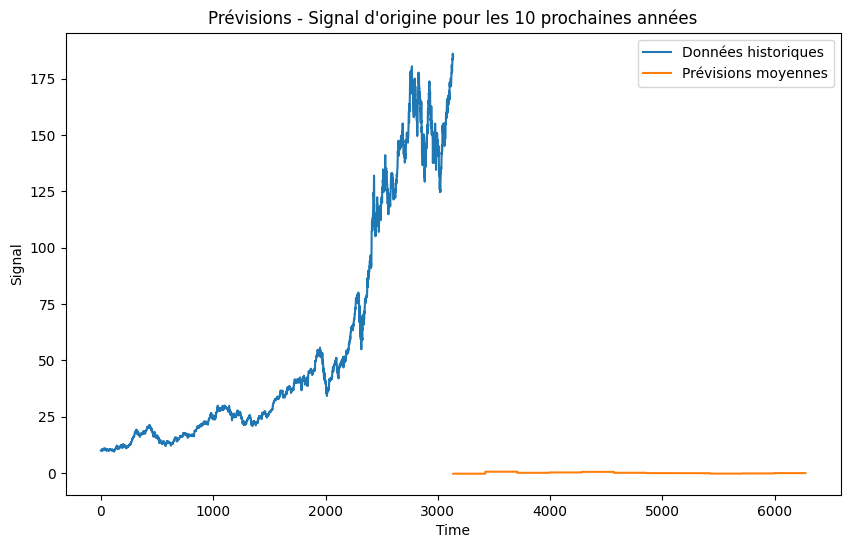

In [10]:
import yfinance as yf
import pywt
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
import numpy as np
import datetime

# Spécifiez le symbole de l'action que vous souhaitez importer
symbol = "AAPL"

# Utilisez la fonction `download` de yfinance pour obtenir les données
data = yf.download(symbol, start="2011-01-01", end=datetime.datetime.now())

# Sélectionnez uniquement la colonne "Adj Close"
adj_close = data["Adj Close"]

# Convertir les données en une liste
signal = adj_close.values.tolist()

# Effectuer la décomposition en ondelettes
coeffs = pywt.wavedec(signal, 'db4', level=4)

# Liste pour stocker les prévisions de chaque niveau de détail
predictions_combined = []

# Prévision des valeurs futures à chaque niveau de détail
for i, detail_level in enumerate(coeffs[1:]):
    # Création du modèle autorégressif (AR) avec un ordre (lag) de 10
    model = AutoReg(detail_level, lags=10)

    # Ajustement du modèle aux données
    model_fit = model.fit()

    # Prévision des valeurs futures à partir du modèle ajusté
    predictions = model_fit.predict(start=len(detail_level), end=len(detail_level) + 10)

    # Ajouter les prédictions au signal combiné
    predictions_combined.append(predictions)

# Transformer les prévisions combinées en un tableau 2D
predictions_combined = np.array(predictions_combined)

# Calculer la moyenne des prévisions pour chaque période de temps
average_predictions = np.mean(predictions_combined, axis=0)

# Répéter les prévisions pour correspondre à la longueur du signal d'origine
repeated_predictions = np.repeat(average_predictions, len(signal) // len(average_predictions) + 1, axis=0)
repeated_predictions = repeated_predictions[:len(signal)]

# Afficher les prévisions moyennes
plt.figure(figsize=(10, 6))
plt.plot(signal, label="Données historiques")
plt.plot(range(len(signal), len(signal) + len(repeated_predictions)), repeated_predictions, label="Prévisions moyennes")
plt.title("Prévisions - Signal d'origine pour les 10 prochaines années")
plt.xlabel("Time")
plt.ylabel("Signal")
plt.legend()
plt.show()

